## Forecasting Demand & Sales || Krista Bogan

This project is attempting to forecast the necessary demand of a product at a single retail store utilizing a couple of different modeling techniques.

The models I created:
1. ETS (Exponential Smoothing)
2. XGBoost (using promotion type)
3. SARIMAX 1 (exogeneous variable being a flag for whether a promotion was running)
4. SARIMAX 2 (exogeneous variable being the actual promotion type)
5. **FINAL MODEL: Ensemble using weights, only including my two best models: ETS and SARIMAX 2.**

Below is the detailed process and code I wrote to generate the final demand forecast.

## EDA

In [1]:
#Importing the necessary libraries
import pandas as pd
import xgboost as xgb
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error


In [2]:
# Load in datasets
sales = pd.read_csv('2022-2024 Clinic Product Sales Data.csv')
promotion = pd.read_csv('Promotion details and dates.csv')

print("Sales Data:")
print(sales.head())
print(sales.shape)
print(sales.isnull().sum())

print("\nPromotion Data:")
print(promotion.head())
print(promotion.shape)
print(promotion.isnull().sum())

Sales Data:
  clinic area clinic name  sale date                         guest user id  \
0    Region B    Clinic G   1/2/2022  2327eb10-952d-431f-8e97-61d37b81944d   
1    Region A    Clinic E   1/5/2022  ace86dd7-8bfc-4c59-ae96-62aeb14fc843   
2    Region B    Clinic G   1/8/2022  668a1fb3-b42f-425b-8252-4876779cc7b3   
3    Region A    Clinic E   1/9/2022  ec01a76e-b6fa-4209-8ffb-0a8b7e7934dd   
4    Region A    Clinic E  1/12/2022  6aa914d4-65e0-4dc1-a211-1c85b3f602a8   

               product name product category  quantity sold  
0  TA Tranexamic Acid Serum            Serum              1  
1     Hyaluronic Acid Serum            Serum              1  
2     Hyaluronic Acid Serum            Serum              1  
3  TA Tranexamic Acid Serum            Serum              1  
4  TA Tranexamic Acid Serum            Serum              1  
(16427, 7)
clinic area         0
clinic name         0
sale date           0
guest user id       0
product name        0
product category    0
quan

In [3]:
# Filtering to get the data for Clinic G and Hyaluronic Acid Serum
filtered_sales = sales[
    (sales['clinic name'] == 'Clinic G') &
    (sales['product name'] == 'Hyaluronic Acid Serum')
]

# Check the filtered data
print(filtered_sales.head())

   clinic area clinic name  sale date                         guest user id  \
2     Region B    Clinic G   1/8/2022  668a1fb3-b42f-425b-8252-4876779cc7b3   
8     Region B    Clinic G  1/15/2022  05e14878-c4a4-44df-b930-95347c9894c2   
9     Region B    Clinic G  1/17/2022  49611d34-d281-445a-b417-8de038783c84   
16    Region B    Clinic G  1/23/2022  9b2b5cf7-8d41-476d-ace1-b358b2040547   
17    Region B    Clinic G  1/24/2022  9f9032a7-ce06-47db-89ec-be4f67af42be   

             product name product category  quantity sold  
2   Hyaluronic Acid Serum            Serum              1  
8   Hyaluronic Acid Serum            Serum              1  
9   Hyaluronic Acid Serum            Serum              1  
16  Hyaluronic Acid Serum            Serum              1  
17  Hyaluronic Acid Serum            Serum              1  


In [4]:
# To forecast, I’d like to perform a time series analysis. First step: Convert the date column to a datetime object in both the sales and promotion data.
filtered_sales["sale date"] = pd.to_datetime(filtered_sales["sale date"])
promotion["start_month"] = pd.to_datetime(promotion["Start Date"])
promotion["end_month"] = pd.to_datetime(promotion["End Date"])

# Extract the month and year from the 'sale date'
filtered_sales["sale month"] = filtered_sales["sale date"].dt.to_period("M")
promotion["start_month"] = promotion["start_month"].dt.to_period("M")
promotion["end_month"] = promotion["end_month"].dt.to_period("M")

/var/folders/5f/89lx5vfn7mqd1zjpfp6t_4n00000gn/T/ipykernel_53350/614589737.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales["sale date"] = pd.to_datetime(filtered_sales["sale date"])
/var/folders/5f/89lx5vfn7mqd1zjpfp6t_4n00000gn/T/ipykernel_53350/614589737.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales["sale month"] = filtered_sales["sale date"].dt.to_period("M")


In [5]:
# I would like to incorporate the promotion data into my forecasting. I am creating a new column for the data that identifies if a promotion was active during that month, and if so, what the promotion was.
filtered_sales["promotion active"] = 0
filtered_sales["promotion name"] = None

for _, promo in promotion.iterrows():
    mask = (filtered_sales["sale month"] >= promo["start_month"]) & (filtered_sales["sale month"] <= promo["end_month"])
    filtered_sales.loc[mask, "promotion active"] = 1
    filtered_sales.loc[mask, "promotion name"] = promo["Promotion"]

# Checking the data again!
filtered_sales.head()

/var/folders/5f/89lx5vfn7mqd1zjpfp6t_4n00000gn/T/ipykernel_53350/1472782697.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales["promotion active"] = 0
/var/folders/5f/89lx5vfn7mqd1zjpfp6t_4n00000gn/T/ipykernel_53350/1472782697.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales["promotion name"] = None


,clinic area,clinic name,sale date,guest user id,product name,product category,quantity sold,sale month,promotion active,promotion name
2,Region B,Clinic G,2022-01-08,668a1fb3-b42f-425b-8252-4876779cc7b3,Hyaluronic Acid Serum,Serum,1,2022-01,1,10% off Serums
8,Region B,Clinic G,2022-01-15,05e14878-c4a4-44df-b930-95347c9894c2,Hyaluronic Acid Serum,Serum,1,2022-01,1,10% off Serums
9,Region B,Clinic G,2022-01-17,49611d34-d281-445a-b417-8de038783c84,Hyaluronic Acid Serum,Serum,1,2022-01,1,10% off Serums
16,Region B,Clinic G,2022-01-23,9b2b5cf7-8d41-476d-ace1-b358b2040547,Hyaluronic Acid Serum,Serum,1,2022-01,1,10% off Serums
17,Region B,Clinic G,2022-01-24,9f9032a7-ce06-47db-89ec-be4f67af42be,Hyaluronic Acid Serum,Serum,1,2022-01,1,10% off Serums


## Descriptive Stats + Insights

#### Key Insights Discovered During the Analysis:
- April 2024 was the best month for selling Hyaluronic Acid at this clinic, coinciding with the "Buy 2, Get Cleanser Free" promotion.
- A total of 829 unique clients purchased Hyaluronic Acid between 2022 and 2024.
- 1,082 sales of the serum were made during promotional periods, while 376 sales occurred when no promotion was running.
- The "30% Off All Products" promotion is the most frequently run promotion at Skin Laundry.
- The best-performing promotions, on average, include "Buy 2, Get Cleanser Free," "Spend More, Save More," and "30% Off All Products."


In [6]:
# Top 5 months with the highest number of hyaluronic acid serum sold
sales_summary = filtered_sales.groupby('sale month')['quantity sold'].sum()
top_5_months = sales_summary.sort_values(ascending=False).head(5)
print("Top 5 Months by Sales:")
print(top_5_months)

# Number of unique clients who purchased hyaulronic acid serum at Clinic G
unique_clients = filtered_sales['guest user id'].nunique()
print(f"\nNumber of Unique Users: {unique_clients}")

# Sales made while Skin Laundry had a promotion vs no promotion
sales_promotion = filtered_sales[filtered_sales['promotion active'] == 1]['quantity sold'].sum()
sales_no_promotion = filtered_sales[filtered_sales['promotion active'] == 0]['quantity sold'].sum()
print(f"\nSales during Promotion: {sales_promotion}")
print(f"Sales without Promotion: {sales_no_promotion}")

Top 5 Months by Sales:
sale month
2024-04    106
2023-11     71
2024-11     68
2024-05     68
2024-07     58
Freq: M, Name: quantity sold, dtype: int64

Number of Unique Users: 829

Sales during Promotion: 1082
Sales without Promotion: 376


                         Promotion  Avg Sales per Month
5         Buy 2, Get Cleanser Free           106.000000
8            Spend more, save more            88.000000
3             30% off all products            68.333333
4                  30% off product            44.000000
2             15% off all products            40.000000
0                   10% off Serums            37.333333
1             10% off all products            34.000000
7  Buy one get one 50% off product            33.500000
6                Buy 3, Get 1 Free            31.000000
The promotion with the highest average sales per month is 'Buy 2, Get Cleanser Free' with an average of 106.00 units sold per month.


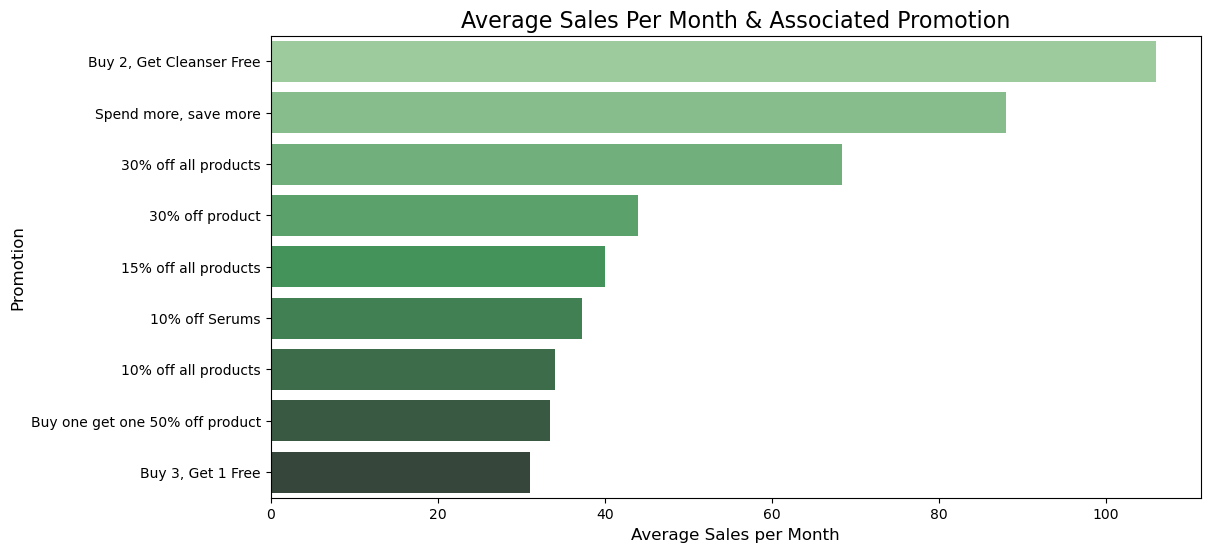

In [7]:
# The top promotion by total sales, on average, per month.
# Group by 'Promotion' and count how many times each promotion has been run
promotion_counts = promotion['Promotion'].value_counts()

# Group by 'Promotion' and sum the total sales for each promotion
promotion_sales = filtered_sales.groupby('promotion name')['quantity sold'].sum()
promotion_avg_sales = promotion_sales / promotion_counts

# Find the promotion with the highest average sales per month
most_avg_sales_promotion = promotion_avg_sales.idxmax()
most_avg_sales_quantity = promotion_avg_sales.max()

# Create a DataFrame to hold the promotion and its average sales per month
promotion_avg_sales_df = pd.DataFrame({
    'Promotion': promotion_avg_sales.index,
    'Avg Sales per Month': promotion_avg_sales.values
})

promotion_avg_sales_df = promotion_avg_sales_df.sort_values('Avg Sales per Month', ascending=False)
print(promotion_avg_sales_df)

print(f"The promotion with the highest average sales per month is '{most_avg_sales_promotion}' with an average of {most_avg_sales_quantity:.2f} units sold per month.")

# Plot the average sales per month for each promotion
plt.figure(figsize=(12, 6))
sns.barplot(x='Avg Sales per Month', y='Promotion', data=promotion_avg_sales_df, palette='Greens_d')
plt.title('Average Sales Per Month & Associated Promotion', fontsize=16)
plt.xlabel('Average Sales per Month', fontsize=12)
plt.ylabel('Promotion', fontsize=12)
plt.show()


# Time-Series Analysis
## Data Prepping, Processing & Plotting
I'm planning to tackle this problem by forecasting on a monthly basis. Since we have data on promotions, it’s key to include that in the analysis. If we were to aggregate the data by quarter, we might miss out on important details about promotions, which usually happen over short periods but can really affect sales in specific months.

In [8]:
filtered_sales['year_month'] = filtered_sales['sale date'].dt.to_period('M')

# Group by 'year_month' and aggregating the data. It looks like per month, there is only one unique promotion, so I decided to take the "first" promotion name/active flag
monthly_sales = filtered_sales.groupby(['year_month', 'clinic name']).agg(
    total_sales=('product name', 'count'),  # Count the number of products sold (you can adjust if you have a 'quantity sold' column)
    promotion_name=('promotion name', 'first'),  # Keep the first promotion name for the month
    promotion_active=('promotion active', 'first')  # Keep the first promotion_active flag for the month
).reset_index()

# Checking to data to make sure it was properly aggregated!
monthly_sales.head()

/var/folders/5f/89lx5vfn7mqd1zjpfp6t_4n00000gn/T/ipykernel_53350/2589766241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_sales['year_month'] = filtered_sales['sale date'].dt.to_period('M')


,year_month,clinic name,total_sales,promotion_name,promotion_active
0,2022-01,Clinic G,40,10% off Serums,1
1,2022-02,Clinic G,31,None,0
2,2022-03,Clinic G,28,10% off Serums,1
3,2022-04,Clinic G,34,10% off all products,1
4,2022-05,Clinic G,39,15% off all products,1


In [9]:
# I had some issues here with the period / date time formatting, so I converted 'year_month' to string, and then later to a date time object again when modelling
monthly_sales['year_month'] = monthly_sales['year_month'].astype(str)

# Creating a train/test split, focusing on the data up to June 2024 for training, and data from July 2024 onward for testing.
train_data = monthly_sales[monthly_sales['year_month'] <= '2024-06']  # Data up to June 2024
test_data = monthly_sales[monthly_sales['year_month'] >= '2024-07']  # Data from July 2024 onward

## Plotting the data

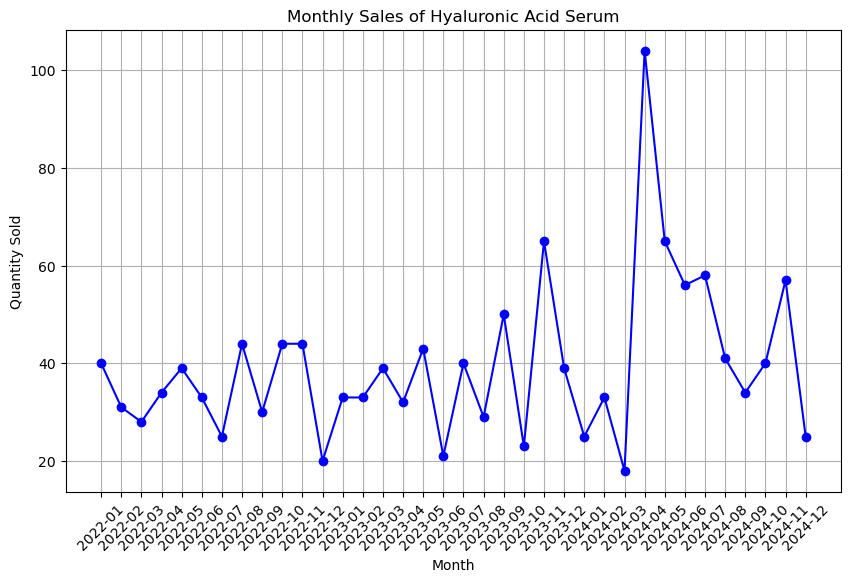

In [10]:
# Plot the overall sales data to see potential seasonality and trend.
plt.figure(figsize=(10,6))
plt.plot(monthly_sales['year_month'].astype(str), monthly_sales['total_sales'], marker='o', linestyle='-', color='b')
plt.title('Monthly Sales of Hyaluronic Acid Serum')
plt.xlabel('Month')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

## Stationarity, STL decomposition, and ACF/PACF

In [11]:
# Looking at this graph, there doesn't seem to be a clear trend. However, there might be some seasonality (specifically multiplicative)
# I first wanted to check stationarity before proceeding with any time series analysis

# Perform ADF test
result = adfuller(monthly_sales['total_sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -5.441512125715841
p-value: 2.7695416566864163e-06


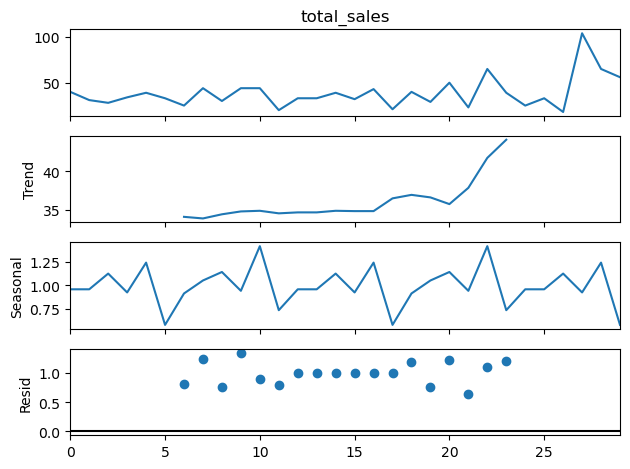

In [12]:
# The data is stationary! No need to take any differences or perform any transformations.
# To get a better understanding of the seasonality and trend, I performed STL decomposition.
decomposition = sm.tsa.seasonal_decompose(train_data['total_sales'], model='multiplicative', period=12)
decomposition.plot()
plt.show()

36


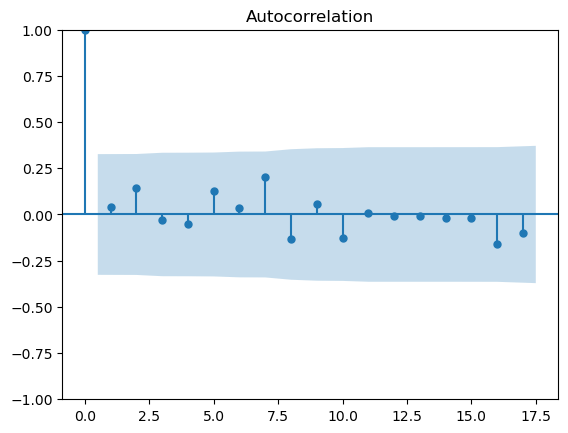

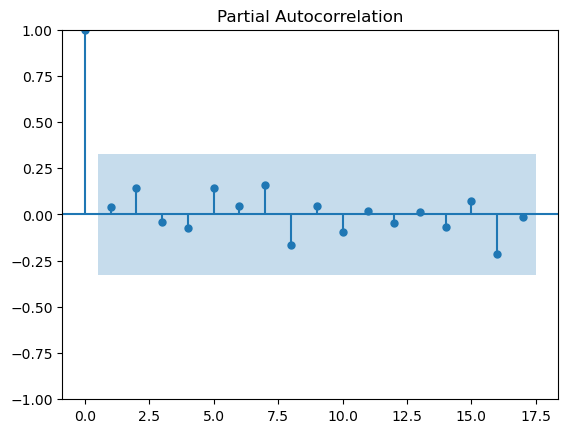

In [13]:
# Looks like there is  seasonality here, as well as a potentially non-linear trend
# I wanted to plot the ACF and PACF plots to see if there are any clear patterns in the lags

num_data_points = len(monthly_sales['total_sales'])
print(num_data_points) # Must have less than half of the observations in lags, thus I chose 17
plot_acf(monthly_sales['total_sales'], lags=17)
plot_pacf(monthly_sales['total_sales'], lags=17)
plt.show()

# Forecasting -- ETS (Exponential Smoothing)

In [14]:
# No significant lags, but because of the STL decomposition, I am going to proceed with analyzing seasonality.
# I am starting off with a simple ETS model to forecast July 2024-September 2024, as ETS can handle somewhat non-linear trends.

# Fit ETS model (Additive trend and multiplicative seasonality)
ets_model = ExponentialSmoothing(train_data['total_sales'], 
                                  trend='add', 
                                  seasonal='multiplicative', 
                                  seasonal_periods=12).fit()

# Create the forecast index for July 2024 to September 2024
forecast_index = pd.date_range(start='2024-07-01', periods=3, freq='M')

# Forecast the next 5 months (July-Dec 2024) using the ETS model
forecast_ets = ets_model.forecast(steps=3)  # Forecast for the next 3 months


In [15]:
# Extract actual values from the test dataset for comparison
actual_values = test_data['total_sales'].head(3) 

# Calculating accuracy metrics
mape = np.mean(np.abs((actual_values - forecast_ets) / actual_values)) * 100
ETSforecast = forecast_ets
print(f"Predictions for July to September 2024: {ETSforecast}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# The ETS model gave me a MAPE of 35.49%. I wanted to see if I could improve this by using a more complex model.

Predictions for July to September 2024: 30    46.678272
31    49.081064
32    56.859330
dtype: float64
Mean Absolute Percentage Error (MAPE): 35.48781896684816%


# Forecasting -- XGBoost

In [16]:
# I also wanted to try an XGBoost model to see if it better captures some of the non-linear trends in the data.

# Convert 'year_month' to datetime and extract features
monthly_sales['year_month'] = pd.to_datetime(monthly_sales['year_month'])
monthly_sales['year'] = monthly_sales['year_month'].dt.year
monthly_sales['month'] = monthly_sales['year_month'].dt.month

# Filter the data for the period July 2024 to September 2024
filtered_sales = monthly_sales[(monthly_sales['year'] == 2024) & (monthly_sales['month'].between(7, 9))]

# Define features (X) and target (y)
X = filtered_sales[['year', 'month', 'promotion_name']]  # Including categorical 'promotion_name'
y = filtered_sales['total_sales']

# Define preprocessing for categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('promo', OneHotEncoder(), ['promotion_name'])  # Apply OneHotEncoder to 'promotion_name'
    ], remainder='passthrough'  # Leave other columns (numerical ones) as is
)

# Create a pipeline with preprocessing and model fitting
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1))
])

# Split data into training and test sets
train_data = monthly_sales[(monthly_sales['year'] < 2024) | ((monthly_sales['year'] == 2024) & (monthly_sales['month'] < 7))]
test_data = filtered_sales  # This is the data for July to September 2024

X_train = train_data[['year', 'month', 'promotion_name']]
y_train = train_data['total_sales']

X_test = test_data[['year', 'month', 'promotion_name']]
y_test = test_data['total_sales']

# Train the model
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(f"Predictions for July to September 2024: {preds}")

# Calculate and print MAPE
mape = mean_absolute_percentage_error(y_test, preds)
print(f"MAPE: {mape * 100:.2f}%")

Predictions for July to September 2024: [57.210167 64.72166  65.12285 ]
MAPE: 50.25%


# Forecasting -- SARIMAX
### I decided to run a SARIMAX model twice: once using whether a promotion was active during the month as the exogenous variable, and again using the promotion type.

### 1. SARIMAX -- Active Promotion Variable

In [17]:
# Starting fresh and converting the train/test data to datetime objects
train_data['year_month'] = pd.to_datetime(train_data['year_month'])
test_data['year_month'] = pd.to_datetime(test_data['year_month'])

# Set 'year_month' as the index for both train and test data
train_data.set_index('year_month', inplace=True)
test_data.set_index('year_month', inplace=True)


/var/folders/5f/89lx5vfn7mqd1zjpfp6t_4n00000gn/T/ipykernel_53350/3736797145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['year_month'] = pd.to_datetime(train_data['year_month'])
/var/folders/5f/89lx5vfn7mqd1zjpfp6t_4n00000gn/T/ipykernel_53350/3736797145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['year_month'] = pd.to_datetime(test_data['year_month'])


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65638D-01    |proj g|=  1.77679D-03

At iterate    5    f=  8.83656D-01    |proj g|=  1.17660D-02

At iterate   10    f=  8.57467D-01    |proj g|=  2.74784D-01

At iterate   15    f=  8.06118D-01    |proj g|=  2.70594D-02

At iterate   20    f=  8.04693D-01    |proj g|=  1.38445D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     29      1     0     0   1.384D-07   8.047D-01
  F =  0.80469294041137651     

CONVERG

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


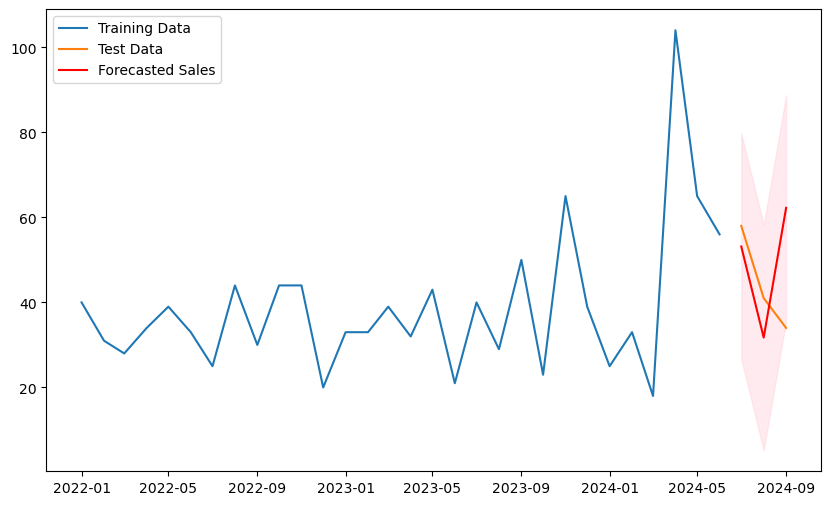

                                SARIMAX Results                                 
Dep. Variable:              total_sales   No. Observations:                   30
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 -24.141
Date:                  Thu, 09 Jan 2025   AIC                             54.282
Time:                          21:23:18   BIC                             53.657
Sample:                      01-01-2022   HQIC                            51.781
                           - 06-01-2024                                         
Covariance Type:                    opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
promotion_active    87.0525    300.651      0.290      0.772    -502.213     676.318
ar.S.L12            -0.1825      0.598     -0.305      0.760      -1.355       0.990
sigma2      

In [18]:
# I think that this data can be modeled using a SARIMAX model, as it can handle seasonality and exogenous variables. I will use the promotion_active column as an exogenous variable.
# I'm using the seasonal order (0, 0, 0)(1, 1, 0)[12] because the data shows strong yearly seasonality, and the seasonal autoregressive term with differencing captures the trend, while excluding the moving average keeps the model simple and focused on the seasonality.
model = sm.tsa.statespace.SARIMAX(train_data['total_sales'], 
                                  exog=train_data[['promotion_active']], 
                                  order=(0, 0, 0), 
                                  seasonal_order=(1, 1, 0, 12),  # Only seasonal component
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

# Fit the model
results = model.fit()

# Filter the test data to only include the forecast period (07-2024 to 09-2024)
forecast_start_date = '2024-07-01'
forecast_end_date = '2024-09-30'
forecast_test_data = test_data[(test_data.index >= forecast_start_date) & (test_data.index <= forecast_end_date)]
forecast_test_exog = test_data[['promotion_active']].loc[forecast_test_data.index]

# Forecast the future values (for 07-2024 to 09-2024)
forecast = results.get_forecast(steps=len(forecast_test_data), exog=forecast_test_exog)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['total_sales'], label='Training Data')
plt.plot(forecast_test_data.index, forecast_test_data['total_sales'], label='Test Data')
plt.plot(forecast_test_data.index, forecast.predicted_mean, label='Forecasted Sales', color='red')
plt.fill_between(forecast_test_data.index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()

# Print model summary
print(results.summary())

# Calculate MAPE
# Forecasted values from the SARIMAX model
forecasted_values = forecast.predicted_mean
SARIMAX1forecast = forecasted_values

# Actual values from the test set (for the forecast period)
actual_values = forecast_test_data['total_sales']

# Calculate the MAPE (Mean Absolute Percentage Error)
ape = np.abs((actual_values - forecasted_values) / actual_values) * 100
mape = np.mean(ape)

# Print the MAPE value
print(f'MAPE: {mape:.2f}%')


### 2. SARIMAX -- Promotion Type

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33727D-01    |proj g|=  6.93658D-03

At iterate    5    f=  6.87648D-01    |proj g|=  2.11463D-02

At iterate   10    f=  6.83391D-01    |proj g|=  8.58323D-03

At iterate   15    f=  6.82949D-01    |proj g|=  1.63156D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     16     19      1     0     0   5.239D-08   6.829D-01
  F =  0.68294901892521254     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


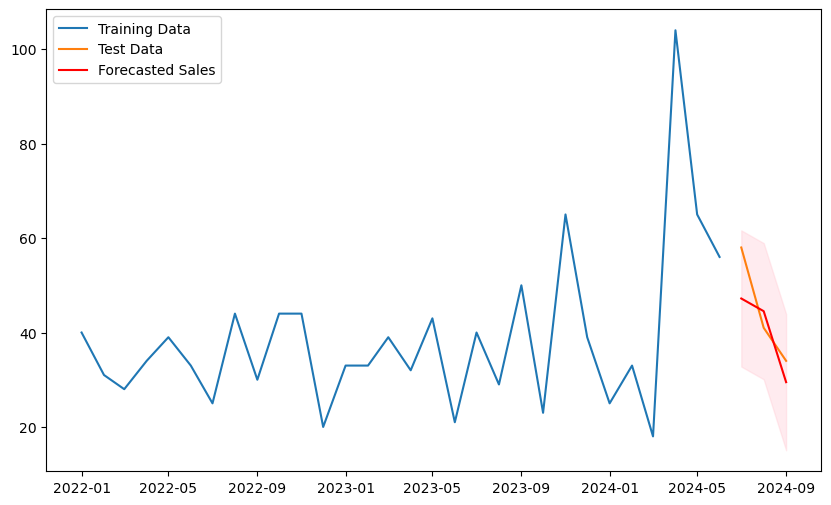

                                SARIMAX Results                                 
Dep. Variable:              total_sales   No. Observations:                   30
Model:             SARIMAX(1, 1, 0, 12)   Log Likelihood                 -20.488
Date:                  Thu, 09 Jan 2025   AIC                             60.977
Time:                          21:23:18   BIC                             58.895
Sample:                      01-01-2022   HQIC                            52.641
                           - 06-01-2024                                         
Covariance Type:                    opg                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
10% off all products                2.0000   3.17e+06   6.31e-07      1.000   -6.21e+06    6.21e+06
15% off all products              -23.5000   3.19e+0

In [19]:
# Create dummy variables for the 'promotion_name' column
train_data_dummies = pd.get_dummies(train_data['promotion_name'], drop_first=True)
test_data_dummies = pd.get_dummies(test_data['promotion_name'], drop_first=True)

# Ensure the dummy variables match the train and test set lengths
train_data_dummies = train_data_dummies.reindex(train_data.index)
test_data_dummies = test_data_dummies.reindex(test_data.index)

# Ensure that the test data dummies have the same columns as the training data dummies
test_data_dummies = test_data_dummies.reindex(columns=train_data_dummies.columns, fill_value=0)

train_data_dummies = train_data_dummies.astype(float)
test_data_dummies = test_data_dummies.astype(float)

# Filter the test data to only include the forecast period (07-2024 to 09-2024)
forecast_start_date = '2024-07-01'
forecast_end_date = '2024-09-30'
forecast_test_data = test_data[(test_data.index >= forecast_start_date) & (test_data.index <= forecast_end_date)]
forecast_test_dummies = test_data_dummies.loc[forecast_test_data.index]

# Rebuild the SARIMAX model
model = sm.tsa.statespace.SARIMAX(train_data['total_sales'], 
                                  exog=train_data_dummies,  # Use the promotion dummies as exogenous variables
                                  order=(0, 0, 0), 
                                  seasonal_order=(1, 1, 0, 12),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

# Fit the model
results = model.fit()

# Forecast the future values (for 07-2024 to 09-2024)
forecast = results.get_forecast(steps=len(forecast_test_data), exog=forecast_test_dummies)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['total_sales'], label='Training Data')
plt.plot(forecast_test_data.index, forecast_test_data['total_sales'], label='Test Data')
plt.plot(forecast_test_data.index, forecast.predicted_mean, label='Forecasted Sales', color='red')
plt.fill_between(forecast_test_data.index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()
print(results.summary())

# Forecasted values from the SARIMAX model
forecasted_values = forecast.predicted_mean
SARIMAX2forecast = forecasted_values
# Actual values from the test set (for the forecast period)
actual_values = forecast_test_data['total_sales']

# Calculate the absolute percentage error (APE) for each data point
ape = np.abs((actual_values - forecasted_values) / actual_values) * 100

# Calculate the MAPE (Mean Absolute Percentage Error)
mape = np.mean(ape)

# Print the MAPE value
print(f'MAPE: {mape:.2f}%')

# Final Forecasting Model -- Ensemble
### I chose to implement an ensemble method, only including my two best models. For the ensemble, I used a common technique where I took the inverse of the MAPE for each of the models (ETS and SARIMAX with promotion name) to calculate the weights. Then, I combined the forecasts from these models for the three months to generate a demand forecast for the clinic.

In [20]:
# MAPE values in percentage form
mape_ets = 0.3549
mape_sarimax2 = 0.1349

# Inverse of MAPE
inv_ets = 1 / mape_ets
inv_sarimax2 = 1 / mape_sarimax2

# Total inverse MAPE
total_inv_mape = inv_ets + inv_sarimax2

# Normalize to get the weights
weight_ets = inv_ets / total_inv_mape
weight_sarimax2 = inv_sarimax2 / total_inv_mape

# Print weights for each model
print(f"Weight for ETS: {weight_ets:.4f}")
print(f"Weight for SARIMAX2: {weight_sarimax2:.4f}")

# Getting the forecasted values, and manually imputing them into arrays for easy calculation.
print(ETSforecast)
print(SARIMAX2forecast)

ETSforecast = [46.678272, 49.081064, 56.859330] 
SARIMAX2forecast = [47.204799, 44.515403, 29.484596]
actual_values = [58, 41, 34]

ETSvalues = np.array(ETSforecast)
SARIMAX2values = np.array(SARIMAX2forecast)
actual_values = np.array(actual_values)

# Ensemble forecast by weighting the models' forecasts
ensemble_forecast = (weight_ets * ETSvalues + 
                     weight_sarimax2 * SARIMAX2values)

# Print the ensemble forecast and actual values
print("Ensemble Forecast:", ensemble_forecast)
print("Actual Values:", actual_values)


Weight for ETS: 0.2754
Weight for SARIMAX2: 0.7246
30    46.678272
31    49.081064
32    56.859330
dtype: float64
2024-07-01    47.204799
2024-08-01    44.515403
2024-09-01    29.484596
Freq: MS, Name: predicted_mean, dtype: float64
Ensemble Forecast: [47.0597837  45.77287068 37.02410522]
Actual Values: [58 41 34]


In [21]:
Q3_Actual = 58 + 41 + 34
Q3_Forecast = 47.0597837 + 45.77287068 + 37.02410522

print(Q3_Actual)
print(Q3_Forecast)

133
129.8567596


In [22]:
# Save the monthly_sales DataFrame to a CSV file
monthly_sales.to_csv('monthly_sales.csv', index=False)